  # Analyse des ventes d'un supermarché
Les fichiers de notre dataset proviennent du lien suivant : https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data.

L'exercice consiste en la prévision des ventes de milliers de familles de produits vendues dans les magasins Favorita situés en Équateur.

Les données d'entraînement (train.csv) incluent les dates, les informations sur les magasins et les produits, la présence ou non de promotions sur les articles, ainsi que les chiffres de vente.

Des fichiers supplémentaires (dans le dossier data) contiennent des informations complémentaires qui pourraient être utiles pour construire nos modèles.



## 1. Importation des bibliothèques

In [2]:
import pandas as pd # manipulation de données
import re
import matplotlib.pyplot as plt  # visualisations graphiques
import seaborn as sns # visualisations graphiques


##  2. Chargement des fichiers CSV

In [3]:
train = pd.read_csv('train.csv') # contient les ventes journalières par produit et par magasin
stores = pd.read_csv('stores.csv') # donne des informations sur chaque magasin (ville, type, cluster)
transactions = pd.read_csv('transactions.csv') # indique le nombre de transactions effectuées par jour
holidays = pd.read_csv('holidays_events.csv') # liste les jours fériés et événements spéciaux
oil = pd.read_csv('oil.csv') # contient le prix du pétrole (utilisé comme variable externe)

##  3. Prétraitement des colonnes de date

On convertit les colonnes `date` de chaque fichier au format datetime. Cela permettra d'extraire des informations temporelles (jour de semaine, mois) et de faire des jointures sur la date  .

In [4]:
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
oil['date'] = pd.to_datetime(oil['date'])

##  4. Fusion des jeux de données

On combine tous les fichiers ensemble pour obtenir un seul tableau complet (`df`) :

- On fusionne les ventes avec les magasins (`stores`)
- Puis on ajoute les transactions (`transactions`)
- Ensuite le prix du pétrole (`oil`)
- Enfin, on ajoute les jours fériés (`holidays_events`)

La colonne `is_holiday` est créée : elle vaut 1 si c'est un jour férié, sinon 0.

In [5]:
df = train.merge(stores, on='store_nbr', how='left')
df = df.merge(transactions, on=['store_nbr', 'date'], how='left')
df = df.merge(oil, on='date', how='left')

holidays_filtered = holidays[holidays['transferred'] == False][['date', 'type']]
df = df.merge(holidays_filtered, on='date', how='left')
df['is_holiday'] = df['type_y'].notna().astype(int)
df.drop(columns=['type_y'], inplace=True)

##  5. Nettoyage des valeurs manquantes

Certaines colonnes ont des valeurs manquantes :

- `transactions` : remplacées par 0 (pas de transaction = pas de vente)
- `dcoilwtico` (prix pétrole) : complété par interpolation linéaire

Cela permet d'éviter des erreurs lors de l’analyse.

In [6]:
df['transactions'] = df['transactions'].fillna(0)
df['dcoilwtico'] = df['dcoilwtico'].interpolate()

##  6. Création de nouvelles variables

On crée deux nouvelles colonnes à partir de `date` :

- `day_of_week` : nom du jour (ex : lundi, mardi)
- `month` : nom du mois (ex : janvier, février)

Ces colonnes nous aideront à repérer des tendances hebdomadaires ou saisonnières.

In [7]:
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()

##  7. Analyse exploratoire

On vérifie ici :
- le nombre total de lignes et de colonnes (`df.shape`)
- les colonnes ayant des valeurs manquantes (`df.isna().sum()`)
- les statistiques de base (`describe`) sur les ventes (`sales`), les transactions et le prix du pétrole.

Cela donne un bon aperçu de la structure et de la qualité des données.

In [8]:
print('Dimensions :', df.shape)
print('\nValeurs manquantes :\n', df.isna().sum())
df[['sales', 'transactions', 'dcoilwtico']].describe()

Dimensions : (3054348, 15)

Valeurs manquantes :
 id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type_x             0
cluster            0
transactions       0
dcoilwtico      1782
is_holiday         0
day_of_week        0
month              0
dtype: int64


,sales,transactions,dcoilwtico
count,3.054348e+06,3.054348e+06,3.052566e+06
mean,3.590209e+02,1.558656e+03,6.780983e+01
std,1.107286e+03,1.036468e+03,2.568161e+01
min,0.000000e+00,0.000000e+00,2.619000e+01
25%,0.000000e+00,9.310000e+02,4.632000e+01
50%,1.100000e+01,1.332000e+03,5.327867e+01
75%,1.960110e+02,1.980000e+03,9.578000e+01
max,1.247170e+05,8.359000e+03,1.106200e+02


##  8. Visualisations et interprétation

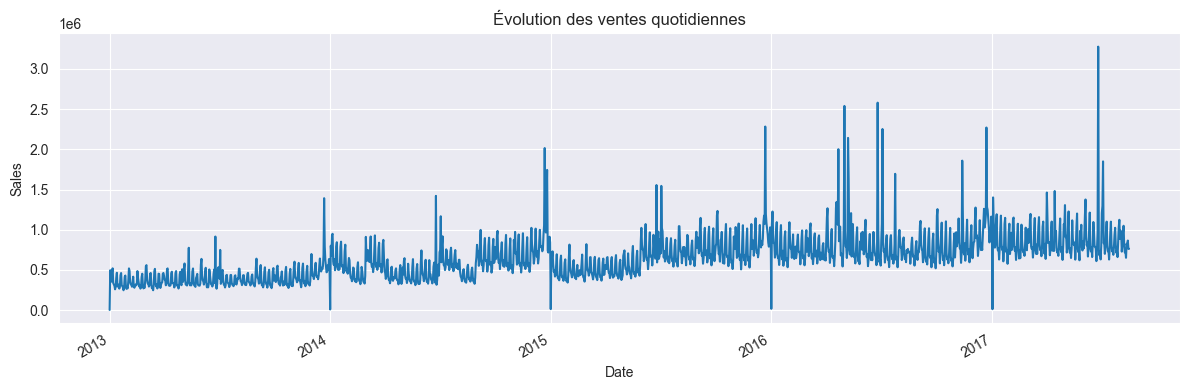

In [9]:
plt.figure(figsize=(12, 4))
df.groupby('date')['sales'].sum().plot()
plt.title('Évolution des ventes quotidiennes')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

Ce graphique montre la somme des ventes journalières sur toute la période.

 **Interprétation** :
On peut observer des pics à certaines périodes de l’année, souvent liés à des événements saisonniers ou jours fériés.
Cela montre une forte saisonnalité dans les ventes.

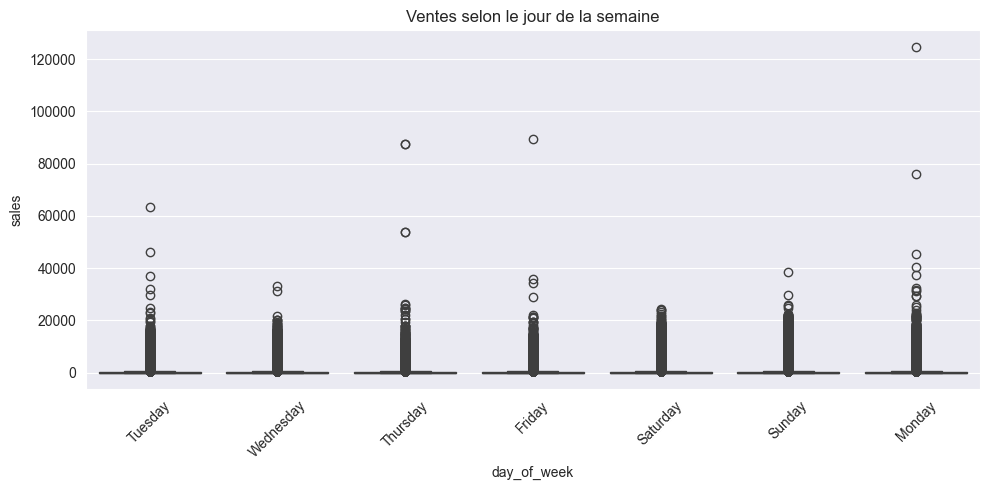

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='day_of_week', y='sales')
plt.title('Ventes selon le jour de la semaine')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ce boxplot montre comment varient les ventes selon les jours (lundi à dimanche).

 **Interprétation** :
Certains jours, comme le samedi ou dimanche, peuvent montrer des ventes plus élevées, selon le comportement des clients.

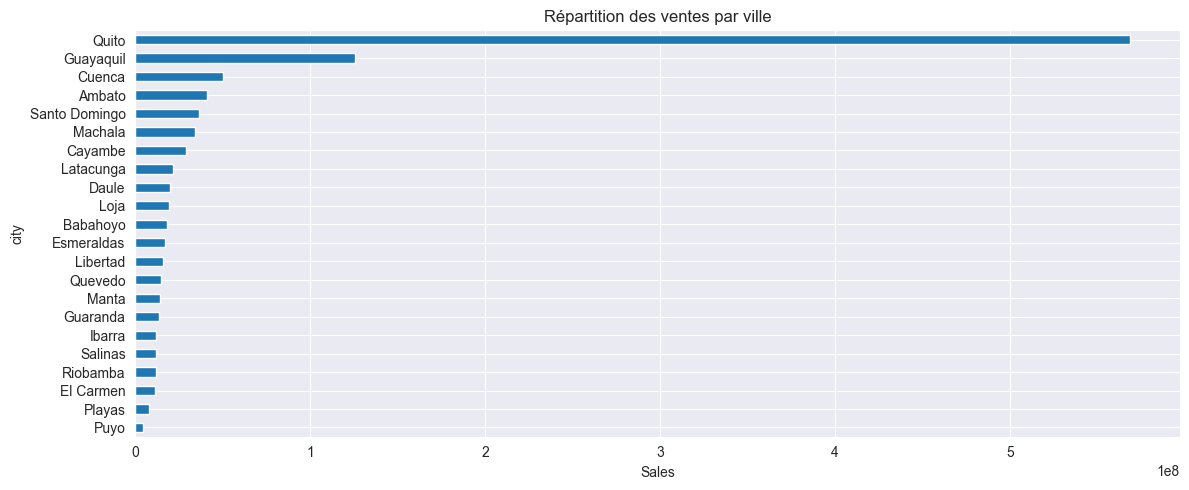

In [11]:
plt.figure(figsize=(12, 5))
df.groupby('city')['sales'].sum().sort_values().plot(kind='barh')
plt.title('Répartition des ventes par ville')
plt.xlabel('Sales')
plt.tight_layout()
plt.show()

Ce graphique permet de comparer le volume total de ventes par ville.

 **Interprétation** :
Les villes les plus peuplées (comme Quito ou Guayaquil) réalisent naturellement plus de ventes.
Cela peut orienter les décisions d’approvisionnement ou de promotions locales.

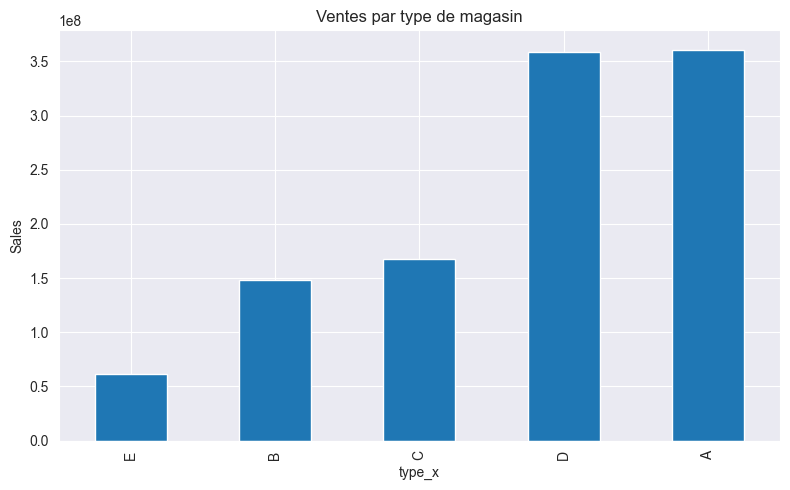

In [12]:
plt.figure(figsize=(8, 5))
df.groupby('type_x')['sales'].sum().sort_values().plot(kind='bar')
plt.title('Ventes par type de magasin')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

On compare ici les ventes totales selon les types de magasins (`type_x`).

 **Interprétation** :
Certains types de magasins (ex : A et D) génèrent plus de ventes. Cela reflète leur taille ou leur positionnement.

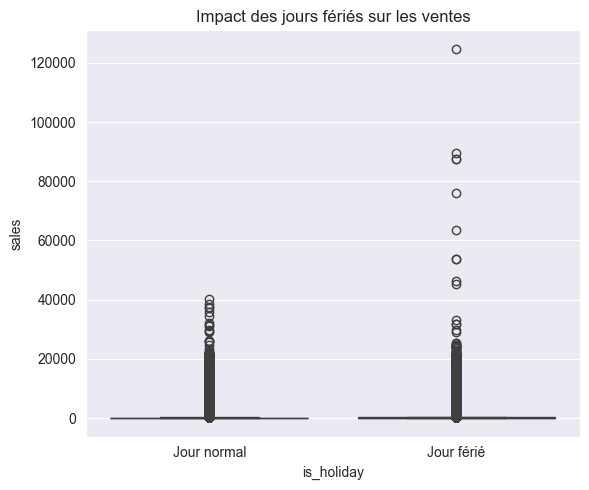

In [13]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x='is_holiday', y='sales')
plt.xticks([0,1], ['Jour normal', 'Jour férié'])
plt.title('Impact des jours fériés sur les ventes')
plt.tight_layout()
plt.show()

On compare les ventes lors des jours fériés (`is_holiday = 1`) avec les jours normaux (`is_holiday = 0`).

 **Interprétation** :
Si les ventes sont plus élevées en jours fériés, cela peut être un levier marketing important. Si elles baissent, il faudra s'adapter.

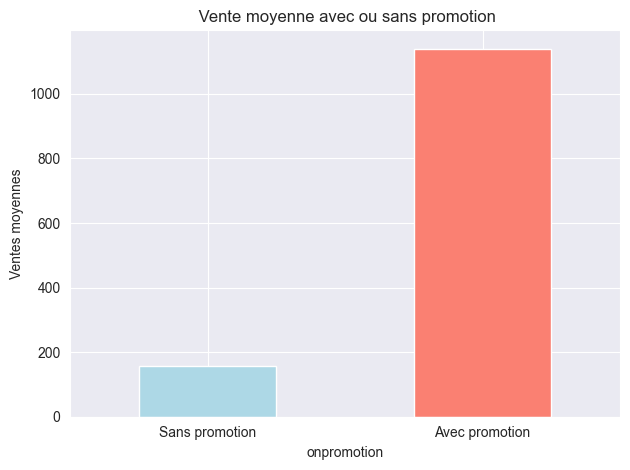

In [14]:
# Comparaison des ventes avec et sans promotion
df['onpromotion'] = df['onpromotion'].fillna(0)  # au cas où certaines valeurs seraient manquantes
df['onpromotion'] = df['onpromotion'].astype(bool)

moyennes_promo = df.groupby('onpromotion')['sales'].mean()

# Visualisation
moyennes_promo.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title(" Vente moyenne avec ou sans promotion")
plt.xticks([0, 1], ['Sans promotion', 'Avec promotion'], rotation=0)
plt.ylabel("Ventes moyennes")
plt.tight_layout()
plt.show()

Ce graphique compare les ventes moyennes des produits selon qu'ils soient en promotion ou non.

On remarque que les ventes sont **significativement plus élevées lorsque les articles sont en promotion**. Cela montre que les campagnes promotionnelles ont un **impact réel sur le comportement d'achat des clients**. En d'autres termes, les promotions attirent plus de consommateurs et boostent la demande, ce qui peut être une stratégie efficace pour augmenter les volumes de vente sur certaines périodes clés.

Ce type d'analyse est essentiel pour les décisions marketing et commerciales.

In [15]:
df.to_csv('data_traites.csv', index=False)

##  10. Wordcloud à partir d'un article

Texte choisi: https://www.insee.fr/fr/statistiques/6204873#:~:text=Les%20ventes%20en%20magasin%20sont,%E2%88%923%2C0%20%25)

In [16]:
article_text = """
En janvier 2022, hausse du chiffre d’affaires des grandes surfaces alimentaires

En janvier 2022, le chiffre d’affaires total des grandes surfaces alimentaires (y compris courses en ligne, drive) repart à la hausse (+2,2 %) après une stabilité en décembre 2021. Les ventes en magasin sont en hausse à la fois pour les produits alimentaires (+1,3 % après +1,1 %) et les produits non alimentaires (+1,8 % après −1,7 %). Concernant les ventes de carburants, le chiffre d'affaires rebondit en janvier (+2,1 % après −3,0 %).

Le chiffre d’affaires des ventes en magasin accélère à la fois dans dans les supermarchés (+1,6 % après +0,6 %) et les hypermarchés (+1,0 % après +0,6 %).

Hausse du chiffre d’affaires sur un an (+6,1 %)

Le chiffre d’affaires réalisé par les grandes surfaces alimentaires au cours des trois derniers mois (novembre 2021 à janvier 2022) est en hausse (+6,1 %) par rapport à la même période un an plus tôt. Les ventes diminuent dans les produits alimentaires (−0,6 %). Elles augmentent en revanche dans les produits non alimentaires (+5,0 %), en raison d'un effet de base lié à la fermeture des rayons de produits considérés comme « non essentiels » lors du deuxième confinement, du 29 octobre au 15 décembre 2020. Les ventes de carburants croissent très fortement (+53,0 %), en raison d'une part de ce même effet de base lié au deuxième confinement et, d'autre part, de la hausse des prix.

En rythme annuel, le chiffre d’affaires de novembre 2021 à janvier 2022 augmente à la fois dans les supermarchés (+5,9 %) et les hypermarchés (+7,8 %)."""

In [17]:
# Modules nécessaires pour l'analyse de textes

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bintoudiop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bintoudiop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Mise en miniscules
article_text.lower()
article_text

"\nEn janvier 2022, hausse du chiffre d’affaires des grandes surfaces alimentaires\n\nEn janvier 2022, le chiffre d’affaires total des grandes surfaces alimentaires (y compris courses en ligne, drive) repart à la hausse (+2,2 %) après une stabilité en décembre 2021. Les ventes en magasin sont en hausse à la fois pour les produits alimentaires (+1,3 % après +1,1 %) et les produits non alimentaires (+1,8 % après −1,7 %). Concernant les ventes de carburants, le chiffre d'affaires rebondit en janvier (+2,1 % après −3,0 %).\n\nLe chiffre d’affaires des ventes en magasin accélère à la fois dans dans les supermarchés (+1,6 % après +0,6 %) et les hypermarchés (+1,0 % après +0,6 %).\n\nHausse du chiffre d’affaires sur un an (+6,1 %)\n\nLe chiffre d’affaires réalisé par les grandes surfaces alimentaires au cours des trois derniers mois (novembre 2021 à janvier 2022) est en hausse (+6,1 %) par rapport à la même période un an plus tôt. Les ventes diminuent dans les produits alimentaires (−0,6 %). 

In [19]:
# Suppression des caractères spéciaux
article_text = re.sub(r'[^a-z\s]', '', article_text)
article_text

'\nn janvier  hausse du chiffre daffaires des grandes surfaces alimentaires\n\nn janvier  le chiffre daffaires total des grandes surfaces alimentaires y compris courses en ligne drive repart  la hausse   aprs une stabilit en dcembre  es ventes en magasin sont en hausse  la fois pour les produits alimentaires   aprs   et les produits non alimentaires   aprs   oncernant les ventes de carburants le chiffre daffaires rebondit en janvier   aprs  \n\ne chiffre daffaires des ventes en magasin acclre  la fois dans dans les supermarchs   aprs   et les hypermarchs   aprs  \n\nausse du chiffre daffaires sur un an  \n\ne chiffre daffaires ralis par les grandes surfaces alimentaires au cours des trois derniers mois novembre   janvier  est en hausse   par rapport  la mme priode un an plus tt es ventes diminuent dans les produits alimentaires   lles augmentent en revanche dans les produits non alimentaires   en raison dun effet de base li  la fermeture des rayons de produits considrs comme  non essen

In [20]:
# Tokenisation simple par expression régulière (mots uniquement)
tokens = re.findall(r'\b\w+\b', article_text)
article_text

'\nn janvier  hausse du chiffre daffaires des grandes surfaces alimentaires\n\nn janvier  le chiffre daffaires total des grandes surfaces alimentaires y compris courses en ligne drive repart  la hausse   aprs une stabilit en dcembre  es ventes en magasin sont en hausse  la fois pour les produits alimentaires   aprs   et les produits non alimentaires   aprs   oncernant les ventes de carburants le chiffre daffaires rebondit en janvier   aprs  \n\ne chiffre daffaires des ventes en magasin acclre  la fois dans dans les supermarchs   aprs   et les hypermarchs   aprs  \n\nausse du chiffre daffaires sur un an  \n\ne chiffre daffaires ralis par les grandes surfaces alimentaires au cours des trois derniers mois novembre   janvier  est en hausse   par rapport  la mme priode un an plus tt es ventes diminuent dans les produits alimentaires   lles augmentent en revanche dans les produits non alimentaires   en raison dun effet de base li  la fermeture des rayons de produits considrs comme  non essen

In [21]:
# Vérif ou téléchargement des stopwords

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

In [22]:
# Suppression des stopwords
stop_words = set(stopwords.words('french'))
filtered_tokens = [word for word in tokens if word not in stop_words]
# Comptage des mots
word_counts = Counter(filtered_tokens)

In [23]:
# Affichage des 10 mots les plus fréquents
print("10 mots les plus fréquents :")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

10 mots les plus fréquents :
chiffre: 7
daffaires: 7
alimentaires: 7
aprs: 6
janvier: 5
hausse: 5
ventes: 5
produits: 5
grandes: 3
surfaces: 3


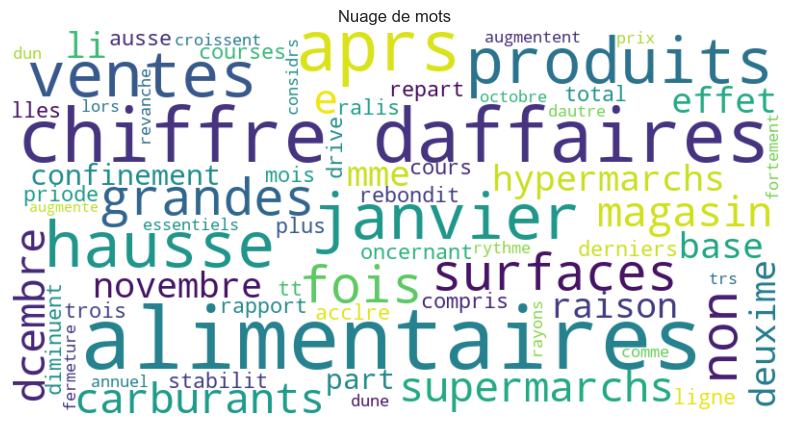

In [24]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots")
plt.show()

##  Conclusion
Avec cette analyse, nous avons pu :
- Identifier les tendances de vente dans le temps
- Observer des variations selon les villes, les jours et les types de magasin
- Mesurer l’impact des jours fériés

Ce travail permettrait à une entreprise comme Favorita de mieux planifier ses opérations et ses stocks.